# Article Recommender

In [1]:
# Data Manipulation
import string
import pandas as pd
import numpy as np

# System 
from time import time

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Similarity Measurement
from sklearn.metrics.pairwise import cosine_similarity

# Normalizations
from sklearn.preprocessing.data import QuantileTransformer

# KMeans Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans

# Text Processing
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

# Entity analysis
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')

# Plotting and Printing
import ipywidgets as widgets
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
% matplotlib inline

# Data

The dataset I used contains around 140k articles and metadata like title, author, publisher and more. It was scraped by [Kaggle](https://www.kaggle.com/snapcrack/all-the-news) member from around 12 publishers and made publicly available.
<b>
- Title	
- Publication
- Author
- Date
- content
</b>

In [2]:
df = pd.read_csv('D:\\Rafal\\CUNY\\643\\final\\data\\articles1.csv', encoding='windows-1252')

#### Metadata

In [3]:
df[['title', 'publication', 'author', 'date']].head()

,title,publication,author,date
0,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31
1,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02


#### Content

In [4]:
# Sample article content
df.content[:1][0][:1000]

'WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been 

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

# Term Frequency - Inverse Document Frequency (TFIDF)


A calculation that reflects how important a word is to an article in a collection of all articles.


## Define TFIDF Vectorizer parameters

In [34]:
vec = TfidfVectorizer(analyzer = 'word',
                      ngram_range = (1,3),
                      stop_words = 'english',
                      lowercase = True,
                      token_pattern = '\w+',
                      min_df=.0025,
                      max_df=.5,
                      norm='l1',
                      sublinear_tf=True)

## Calculate or Load TFIDF Matrix

In [6]:
def calc_tfidf(vec, contents, path):
    
    start_time = time()
    print('Training Begins')  
    tfidf = vec.fit_transform(contents)    
    print("TFIDF in: %s seconds." % round((time() - start_time),2))

    # If path provided, save to tfidf to a file
    if path:
        print("Saving TFIDF as numpy")
        np.save(path, tfidf, allow_pickle=True, fix_imports=True)
    
    show_tfidf_stats(tfidf)
    
    return tfidf

def load_tfidf(path):
    tfidf = np.load(path)
    return tfidf


def show_tfidf_stats(x):
    # Determine shape, count zeros and calculate sparcity percentage
    print('(Articles, Features): ', x.shape)
    print('Non-zero Count: ', x.nnz)
    print('Sparsity: %.2f%%' % (100.0 * x.nnz / (x.shape[0] * x.shape[1])))

In [35]:
#tfidf_save_path = 'D:\\Rafal\\CUNY\\643\\final\\data\\tfidf_mx.pickle'
#tfidf = calc_tfidf(vec, df.iloc[:20000].content, tfidf_save_path)


tfidf_load_path = 'D:\\Rafal\\CUNY\\643\\final\\data\\tfidf_mx.pickle.npy'
tfidf = load_tfidf(tfidf_load_path)

Training Begins
TFIDF in: 77.46 seconds.
Saving TFIDF as numpy
(Articles, Features):  (20000, 19647)
Non-zero Count:  5489650
Sparsity: 1.40%


### TFIDF Calculation Benchmark

   
|TFIDF Calculation Benchmark|
|------|------|
|Data Size | One Node   |
|5k | 26 sec |
|10k | 47 sec | 
|20k | 70 sec | 


<hr style="height:2px;border:none;color:#333;background-color:#333;" />

# Cosine Similarities


"The cosine measure similarity is another similarity metric that depends on envisioning user preferences as points in space.  Hold in mind the image of user preferences as points in an n-dimensional space. Now imagine two lines from the origin, or  point (0,0,…,0), to each of these two points. When two users are similar, they’ll have similar ratings, and so will be  relatively close in space—at least, they’ll be in roughly the same direction from the origin. The angle formed between these two lines will be relatively small. In contrast, when the two users are dissimilar, their points will be distant, and likely in different directions from the origin, forming a wide angle. This angle can be used as the basis for a similarity metric in the same way that the Euclidean distance was used to form a similarity metric. In this case, the cosine of the angle leads to a similarity value. If you’re rusty on trigonometry, all you need to remember to understand this is that the cosine value is always between –1 and 1: the cosine of a small angle is near 1, and the cosine of a large angle near 180 degrees is close to –1. This is good, because small angles should map to high similarity, near 1, and large angles should map to near –1."


From Mahout in Action book


In [8]:
def calc_cossim(tfidf, path):
    
    start_time = time()
    
    # Compute cosine value for every item
    cosine_similarities = cosine_similarity(tfidf, tfidf)
    # reset this.article value from 1 to 0
    #cosine_similarities[cosine_similarities > 0.99] = 0
    print("Calculated Cosine in: %s seconds." % round((time() - start_time),2))
    
    if path:
        print("Saving cosine_similarities as numpy")
        np.save(path, cosine_similarities, allow_pickle=True, fix_imports=True)
        return cosine_similarities
    
    
def load_cossim(path):
    cosine_similarities = np.load(path)
    return cosine_similarities


In [9]:
#cossim_save_path = 'D:\\Rafal\\CUNY\\643\\final\\data\\cos.pickle'
#cossim = calc_cossim(tfidf, cossim_save_path)

cossim_load_path = 'D:\\Rafal\\CUNY\\643\\final\\data\\cos.pickle.npy'
cossim = load_cossim(cossim_load_path)

### Cosine Similarity Calculation Benchmark

   
|Cosine Similarity benchmark|
|------|------|
|Data Size | One Node   | 
|20k | 26 sec |

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

# Recommender in Action

## Entity Recognition


spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including **companies, locations, organizations and products**. You can add arbitrary classes to the entity recognition system, and update the model with new examples.



In [52]:
# Jupyter Reendering of entity types
display(HTML('<h3> %s </h3>' % df.iloc[:1].title[0]))
doc = nlp(df.iloc[:1].content[0][:800])
displacy.render(doc, style='ent', jupyter=True)

In [11]:
def get_entities(content):
    
    doc = nlp(content)
    entities_dict = {}

    for ent in doc.ents:
        entities_dict[ent.text.strip()] = ent.label_

    # Remove empty keys
    entities_dict = dict( [(k,v) for k,v in entities_dict.items() if len(k) > 0])  

    # Convert to pandas
    entities_df = pd.DataFrame(list(entities_dict.items()),
                               columns=['entity','type'])

    people = entities_df[entities_df.type == 'PERSON'].entity.values
    locations = entities_df[entities_df.type == 'LOC'].entity.values
    orgs = entities_df[entities_df.type == 'ORG'].entity.values

    return people, locations, orgs

## Most Common Words

In [12]:
def get_most_common_words(article_content, num_words):
    """ Get most frequent words for a single article """

    # Filter only for words
    tokenizer = RegexpTokenizer(r'\w+')

    # Split into individual words
    # This must be pulled from mdb
    word_tokens = tokenizer.tokenize(article_content)

    # Set Stopwords
    stop_words = set(stopwords.words('english'))

    # Remove Stopwords
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    # Get most common words
    return (FreqDist(filtered_sentence).most_common(num_words))


## Similarity Matching

In [38]:
def sim_articles(art_id, cossim, n_articles=6, n_words=10):

    results = {}
    # Get the most similar articles ids
    most_similar_articles_ids = list(cossim[art_id].argsort()[:-n_articles - 1:-1])
    most_similar_articles_ids = list(map(int, most_similar_articles_ids))
    
    
    for i in most_similar_articles_ids:
        title = df[df.index == i].title.tolist()[0]
        content = df[df.index == i].content.tolist()[0]
        
        # Set up spacy document for entities extraction
        people, locations, orgs = get_entities(content)
        
        results[i] = {'title': title,
                      'people': people,
                      'locations': locations,
                      'orgs': orgs,
                      'mcw': get_most_common_words(content, n_words),
                      'cos': np.round(cossim[art_id][i], 2)}

    return pd.DataFrame(results).T.sort_values('cos', ascending=False)



## Format Results

In [54]:
def print_results(results):
    for i in results.values:
    
        # Organize individual article information into a df for neat html display
        d = {'People': i[4],
             'Locations': i[1],
             'Organizations': i[3],
             'Most Common Words': i[2]}

        tmp_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))   
        tmp_df = tmp_df.replace(np.nan, '', regex=True)

        if float(i[0]) == 1.0:
            display(HTML('<h3> %s </h3>' %str(i[5])))
            display(HTML(tmp_df.head().to_html(index=False)))
            display(HTML('<hr style="height:2px;border:none;color:#333;background-color:#333;" />'))
        else:
            cos = float(i[0])*100
            display(HTML('<h3>' + str(i[5]) +'</h3>'))
            display(HTML('<p><b>Cosine Similarity:</b> %s </h3>' %str(i[0])))
            display(widgets.IntProgress(value=cos, min=0, max=100, step=1,
                                        bar_style='success', orientation='horizontal'))
            display(HTML(tmp_df.head().to_html(index=False)))
        

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

# RECOMMENDER

In [56]:
import qgrid
qg_data = qgrid.show_grid(df.iloc[:200][['title']])
qg_data

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True, 'boldIndex': True}, id='bb825fd6-7d86-4e29-9c44-68afba209b13', precision=5)

In [16]:
# Well Matched sample resuts
# results = sim_articles(30, cossim, 6, 5)
# results = sim_articles(51, cossim, 6, 5)
# results = sim_articles(120, cossim, 6, 5)
# results = sim_articles(130, cossim, 6, 5)
# results = sim_articles(167, cossim, 6, 5)

In [63]:
results = sim_articles(78, cossim, 6, 5)
print_results(results)

Locations,Most Common Words,Organizations,People
the Ocean Medallion,"(Carnival, 21)",DORAL,John Padgett
,"(Disney, 9)",Carnival Corporation,Arnold W. Donald
,"(The, 8)",Disney,Donald
,"(said, 8)",Walt Disney World,David Beckel
,"(Mr, 8)",Carnival,Beckel


IntProgress(value=21, bar_style='success')

Locations,Most Common Words,Organizations,People
the Norwegian Escape,"(said, 19)",Haven,Kevin Sheehan
the Coastal Kitchen,"(Haven, 15)",Delta,Teddy Roosevelt
Central Park,"(Royal, 15)",Porsche,J. P. Morgan
,"(ship, 14)",Walt Disney World,Thomas Sander
,"(people, 12)",Royal Caribbean,Emmanuel Saez


IntProgress(value=17, bar_style='success')

Locations,Most Common Words,Organizations,People
Central Florida,"(Disney, 79)",Disney,Robert A. Iger
,"(China, 39)",Communist Party,Iger
,"(Mr, 36)",the Disney Channel,Yu Zhengsheng
,"(Shanghai, 34)",Magic,Aswath Damodaran
,"(Chinese, 31)",the Communist Party,Jessica Reif Cohen


IntProgress(value=16, bar_style='success')

Locations,Most Common Words,Organizations,People
Silicon Valley,"(Netflix, 141)",Netflix,Ted Sarandos
,"(company, 43)",Palazzo,Sarandos
,"(Hastings, 41)",Venetian,Reed Hastings
,"(would, 33)",the Consumer Electronics Show,Hastings
,"(shows, 33)",Facebook,Saul


IntProgress(value=15, bar_style='success')

Locations,Most Common Words,Organizations,People
Frozen”,"(Disney, 21)",Walt Disney,Anna
,"(Broadway, 13)",Disney,Elsa
,"(The, 11)",Disney California Adventure,Arendelle
,"(Frozen, 8)",Aladdin,Robert A. Iger
,"(theme, 7)",Party People,Liesl Tommy


IntProgress(value=15, bar_style='success')

Locations,Most Common Words,Organizations,People
,"(said, 12)",Princess Cruise Lines,John C. Cruden
,"(Princess, 11)",the Justice Department,Cruden
,"(ship, 10)",Office for the Southern District,
,"(waste, 6)",Maritime and Coastguard Agency,
,"(Cruise, 4)",the Department of Justice’s Environment and Na...,


<hr style="height:2px;border:none;color:#333;background-color:#333;" />

# Topic Modeling - KNN clustering

In [21]:
# QuantileTransformer with Gaussian normal distribution
start_time = time()

normalized = QuantileTransformer(output_distribution='normal').fit_transform(cossim)

print("Normalized in: %s seconds." % round((time() - start_time),2))

Normalized in: 153.95 seconds.


In [23]:
# Kmeans Params
n_clusters = 4
km_mini = MiniBatchKMeans(n_clusters)

In [2]:
start_time = time()

# Kmeans Mini Fitting
km_mini.fit(normalized)
y_kmini = km_mini.predict(normalized)
centers_kmini = km_mini.cluster_centers_

print("Kmeans Mini in: %s seconds." % round((time() - start_time),2))

NameError: name 'time' is not defined

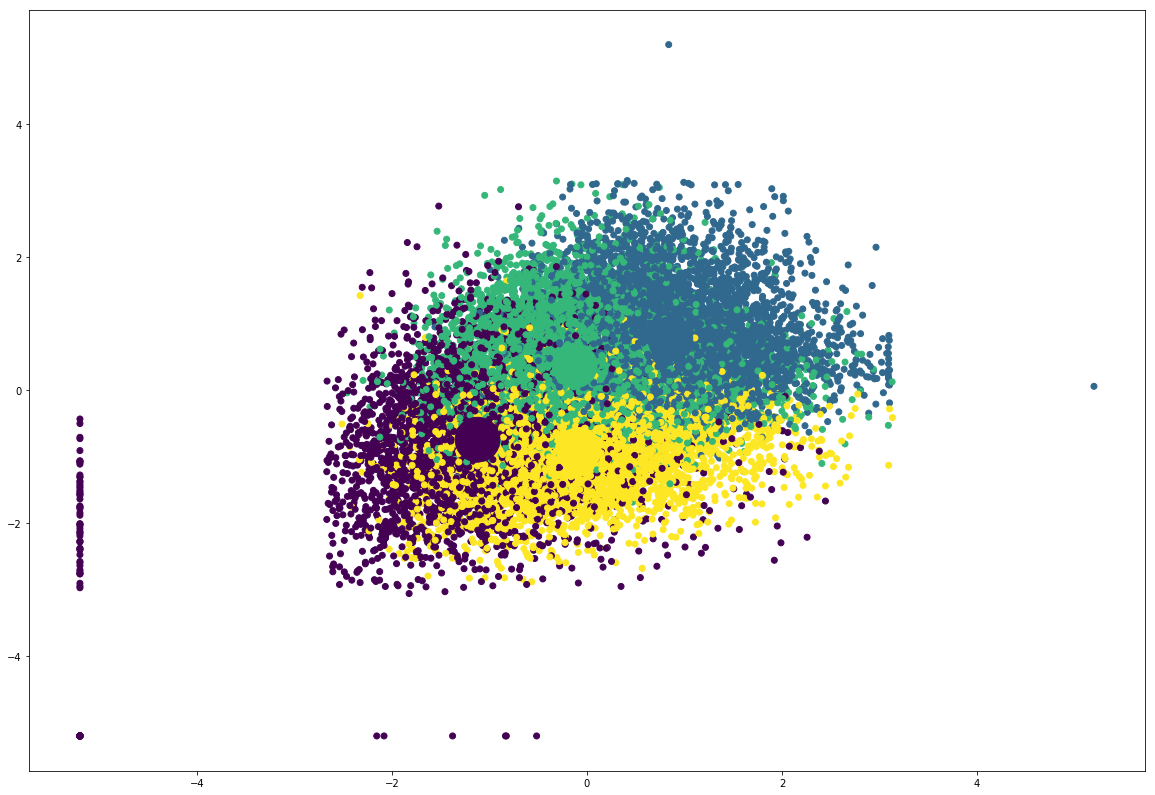

In [31]:
# Kmeans Mini PLotting
plt.figure(figsize=(20,14))
colors_mini = list(range(0,len(centers_kmini)))
plt.scatter(normalized[:, 0], normalized[:, 1], c=y_kmini, cmap='viridis')
plt.scatter(centers_kmini[:, 0], centers_kmini[:, 1], c=colors_mini, s=2000, cmap='viridis')

In [1]:
order_centroids = km_mini.cluster_centers_.argsort()[:, ::-1]

clustered_terms = {}

terms = vec.get_feature_names()

for i in range(0,n_clusters):    
    cluster_terms = []
    
    for ind in order_centroids[i, :]:
        terms[ind] = terms[ind][0].str.replace('[^a-zA-Z]', '')
        cluster_terms.append(terms[ind])
    
    clustered_terms[i] = cluster_terms
    

clustered_terms_df = pd.DataFrame(clustered_terms)  
clustered_terms_df[0] = clustered_terms_df[0].str.replace('\d+', '')

clustered_terms_df[0] = clustered_terms_df[0].str.replace('[^a-zA-Z]', '')
clustered_terms_df[1] = clustered_terms_df[1].str.replace('[^a-zA-Z]', '')
clustered_terms_df[2] = clustered_terms_df[2].str.replace('[^a-zA-Z]', '')
clustered_terms_df[3] = clustered_terms_df[3].str.replace('[^a-zA-Z]', '')

clustered_terms_df

NameError: name 'km_mini' is not defined

Cluster 0 

- Terrorism & Military
- Money (financial crisis, 
- Politics (presidents, visas, senate)
- Education (students), Health (diabetes, laws), Science (earthquake)
- Jobs (employees)


# References

**TF-IDF with nice visuals**

https://janav.wordpress.com/2013/10/27/tf-idf-and-cosine-similarity/


**sklearn API**

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    
    